<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/Baryonator/blob/main/notebooks/JaxPM_Lensing_Map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## copied from https://github.com/DifferentiableUniverseInitiative/JaxPM/blob/main/notebooks/lensing_demo.ipynb
## we want to convert this later to include gas stuff too

In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import logging

logger = logging.getLogger("root")

class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

In [4]:
#!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/JaxPM.git

In [5]:
import jax
import jax.numpy as jnp

import jax_cosmo as jc

from jax.experimental.ode import odeint
from jaxpm.painting import cic_paint, cic_paint_2d
from jaxpm.pm import linear_field, lpt, make_ode_fn
from jaxpm.lensing import density_plane, convergence_Born

import pdb

In [69]:
# Below are a few parameters that generate a low resolution version of the k-TNG simulation

box_size = [200.,200.,4000.]    # Transverse comoving size of the simulation volume
nc = [64, 64, 320]              # Number of transverse voxels in the simulation volume
lensplane_width = 102.5         # Width of each lensplane
field_size = 5                  # Size of the lensing field in degrees
field_npix = 128                # Number of pixels in the lensing field
z_source = jnp.linspace(0,2)    # Source planes

In [70]:
# Defining the coordinate grid for lensing map
import astropy.units as u
xgrid, ygrid = np.meshgrid(np.linspace(0, field_size, field_npix, endpoint=False), # range of X coordinates
                           np.linspace(0, field_size, field_npix, endpoint=False)) # range of Y coordinates

coords = np.stack([xgrid, ygrid], axis=0)*u.deg
c = coords.reshape([2, -1]).T.to(u.rad)

In [71]:
print(coords)

[[[0.        0.0390625 0.078125  ... 4.8828125 4.921875  4.9609375]
  [0.        0.0390625 0.078125  ... 4.8828125 4.921875  4.9609375]
  [0.        0.0390625 0.078125  ... 4.8828125 4.921875  4.9609375]
  ...
  [0.        0.0390625 0.078125  ... 4.8828125 4.921875  4.9609375]
  [0.        0.0390625 0.078125  ... 4.8828125 4.921875  4.9609375]
  [0.        0.0390625 0.078125  ... 4.8828125 4.921875  4.9609375]]

 [[0.        0.        0.        ... 0.        0.        0.       ]
  [0.0390625 0.0390625 0.0390625 ... 0.0390625 0.0390625 0.0390625]
  [0.078125  0.078125  0.078125  ... 0.078125  0.078125  0.078125 ]
  ...
  [4.8828125 4.8828125 4.8828125 ... 4.8828125 4.8828125 4.8828125]
  [4.921875  4.921875  4.921875  ... 4.921875  4.921875  4.921875 ]
  [4.9609375 4.9609375 4.9609375 ... 4.9609375 4.9609375 4.9609375]]] deg


In [72]:
print(c)

[[0.         0.        ]
 [0.00068177 0.        ]
 [0.00136354 0.        ]
 ...
 [0.08522115 0.08658469]
 [0.08590292 0.08658469]
 [0.08658469 0.08658469]] rad


In [8]:
#@jax.jit
def make_map(Omega_c=0.2589, sigma8=0.8159):
    # Instantiates a cosmology with desired parameters
    cosmology = jc.Planck15(Omega_c=Omega_c, sigma8=sigma8)

    # Planning out the scale factor stepping to extract desired lensplanes
    n_lens = int(box_size[-1] // lensplane_width)
    r = jnp.linspace(0., box_size[-1], n_lens+1)
    r_center = 0.5*(r[1:] + r[:-1])

    # Retrieve the scale factor corresponding to these distances
    a = jc.background.a_of_chi(cosmology, r)
    a_center = jc.background.a_of_chi(cosmology, r_center)

    # Then one step per lens plane
    stages = a_center[::-1]

    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(cosmology, k)
    pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)

    # Create initial conditions
    initial_conditions = linear_field(nc, box_size, pk_fn, seed=jax.random.PRNGKey(0))

    # Create particles
    particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in nc]),axis=-1).reshape([-1,3])

    cosmo = jc.Planck15(Omega_c=Omega_c, sigma8=sigma8)

    # Initial displacement
    dx, p, f = lpt(cosmo, initial_conditions, particles, 0.1)

    # Evolve the simulation forward
    res = odeint(make_ode_fn(nc), [particles+dx, p],
                 jnp.concatenate([jnp.atleast_1d(0.1), stages]), cosmo, rtol=1e-5, atol=1e-5)

    
    # Extract the lensplanes
    lensplanes = []
    for i in range(len(a_center)):
        dx = box_size[0]/64
        dz = lensplane_width
        plane = density_plane(res[0][::-1][i],
                              nc,
                              (i+0.5)*lensplane_width/box_size[-1]*nc[-1],
                              width=lensplane_width/box_size[-1]*nc[-1],
                              plane_resolution=64
                           )
        
        lensplanes.append({'r': r_center[i],
                           'a': stages[::-1][i],
                           'plane': plane,
                           'dx':dx,
                           'dz':dz})

    # Get convergence map
    m = convergence_Born(cosmology,
                          lensplanes,
                          coords=jnp.array(c).T.reshape(2,field_npix,field_npix),
                          z_source=z_source)
    return m

In [37]:
m = make_map()

In [9]:
res_all = np.load('res.npz')['res']

<ipython-input-30-7bf1b0e4da1e>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(3,3))


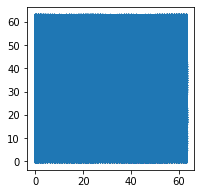

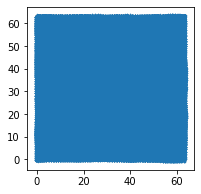

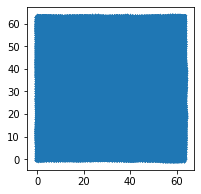

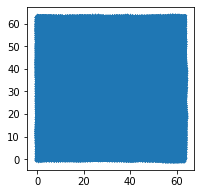

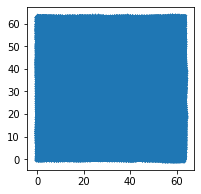

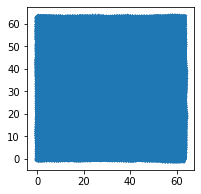

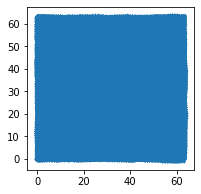

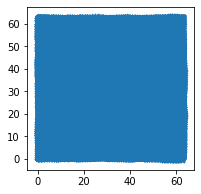

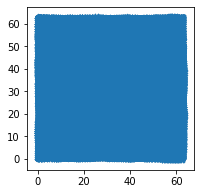

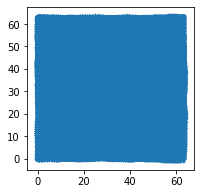

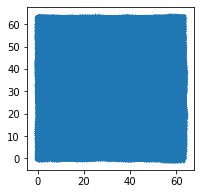

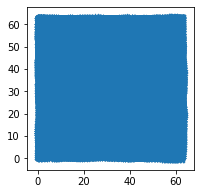

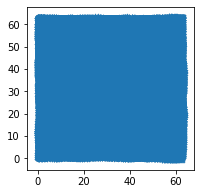

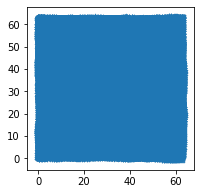

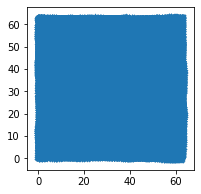

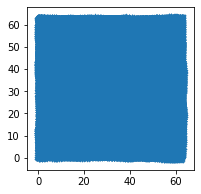

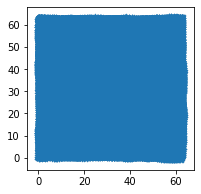

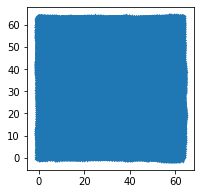

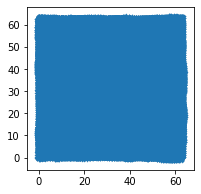

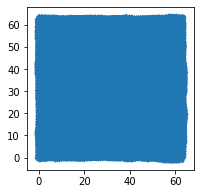

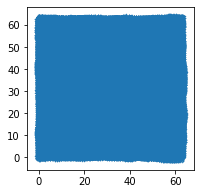

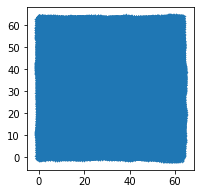

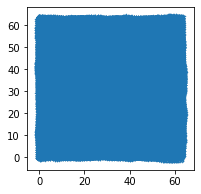

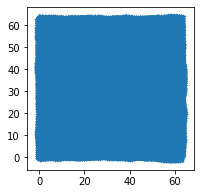

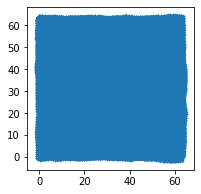

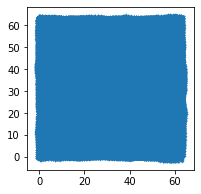

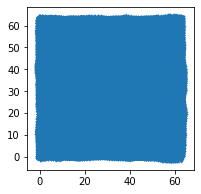

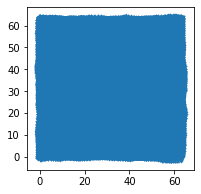

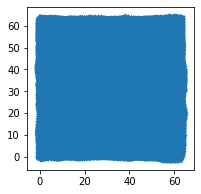

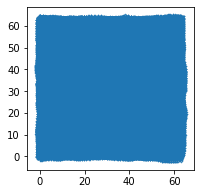

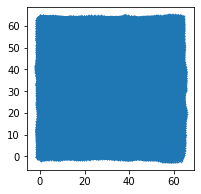

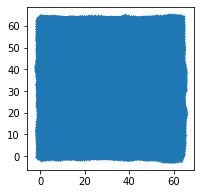

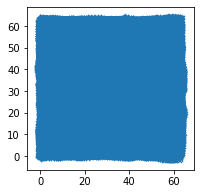

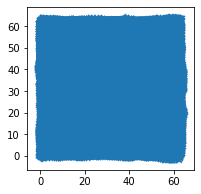

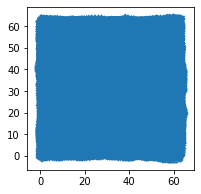

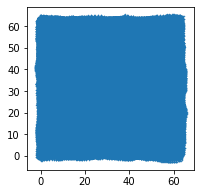

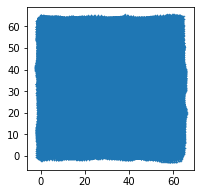

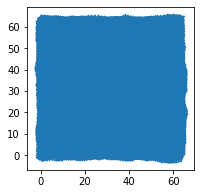

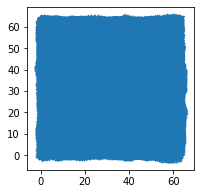

In [30]:
for i in range(39):
    figure(figsize=(3,3))
    scatter(res_all[0][::-1][39-i][:,0], res_all[0][::-1][39-i][:,1], marker = '.', s=1)



In [ ]:
%timeit m = make_map()

16.6 s ± 224 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
figure(figsize=[20,20])
for i in range(39):
    subplot(7,7,i+1)
    imshow(lensplanes[i][-1])
    axis('off')

## Break down the code

In [9]:
Omega_c=0.2589
sigma8=0.8159

# Instantiates a cosmology with desired parameters
cosmology = jc.Planck15(Omega_c=Omega_c, sigma8=sigma8)

In [10]:
# Planning out the scale factor stepping to extract desired lensplanes
n_lens = int(box_size[-1] // lensplane_width)
r = jnp.linspace(0., box_size[-1], n_lens+1)
r_center = 0.5*(r[1:] + r[:-1])

# Retrieve the scale factor corresponding to these distances
a = jc.background.a_of_chi(cosmology, r)
a_center = jc.background.a_of_chi(cosmology, r_center)

# Then one step per lens plane
stages = a_center[::-1]

/Users/chihwaychang/anaconda3/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


In [11]:
print(n_lens)
print(r) # Mpc/h
print(a)
print(1/a-1)
print(stages) # inverse the a array

39
[   0.       102.5641   205.1282   307.69232  410.2564   512.8205
  615.38464  717.9487   820.5128   923.0769  1025.641   1128.2051
 1230.7693  1333.3334  1435.8975  1538.4615  1641.0256  1743.5897
 1846.1538  1948.7179  2051.282   2153.8462  2256.4102  2358.9744
 2461.5386  2564.1025  2666.6667  2769.2307  2871.795   2974.359
 3076.923   3179.487   3282.0513  3384.6155  3487.1794  3589.7437
 3692.3076  3794.8718  3897.4358  4000.     ]
[1.         0.96648914 0.9350955  0.9045976  0.8759237  0.8484709
 0.82215273 0.7968894  0.77227825 0.7490165  0.7265936  0.7049547
 0.6840498  0.6638329  0.64426136 0.6252965  0.6069021  0.58885694
 0.57155764 0.55473363 0.53835976 0.52241284 0.5068715  0.4917162
 0.47692847 0.46249175 0.44829586 0.4345553  0.42112112 0.40798104
 0.39512417 0.38253996 0.37016335 0.3581362  0.34635428 0.33480984
 0.3234479  0.3123989  0.30156696 0.290895  ]
[0.         0.03467274 0.06940949 0.10546398 0.14165199 0.17859077
 0.21631896 0.25487924 0.29487014 0.33508408

In [12]:
# Create a small function to generate the matter power spectrum
k = jnp.logspace(-4, 1, 128)
pk = jc.power.linear_matter_power(cosmology, k)
pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)

/Users/chihwaychang/anaconda3/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


[[  887.1177    311.53046]
 [  150.77353 19682.48   ]]


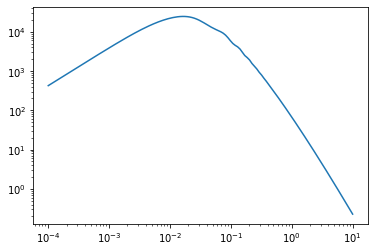

In [13]:
loglog(k, pk)

test_x = np.array([[0.3,0.5], [0.7,0.03]])
print(pk_fn(test_x))

In [14]:
test_x.reshape([-1]) # this just flattens the array, cool

array([0.3 , 0.5 , 0.7 , 0.03])

In [15]:
# Create initial conditions
initial_conditions = linear_field(nc, box_size, pk_fn, seed=jax.random.PRNGKey(0))

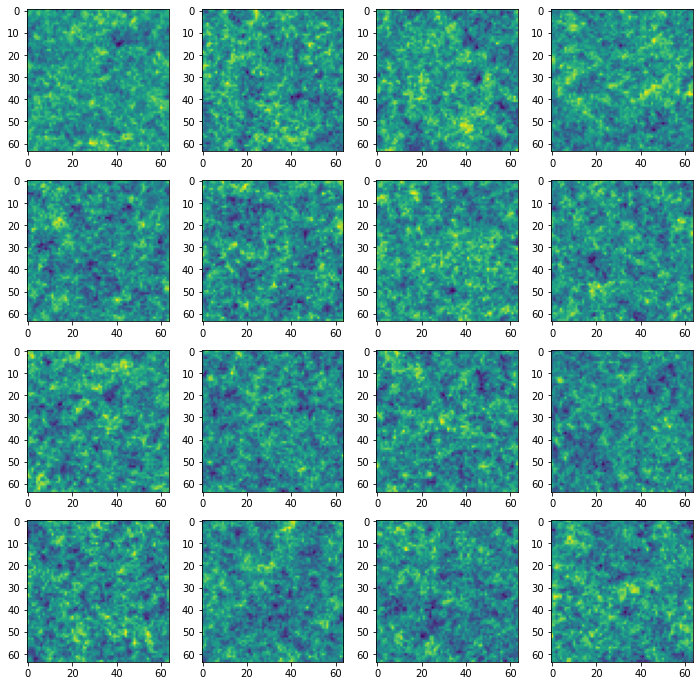

In [16]:
figure(figsize=(12,12))
for i in range(16):
    subplot(4,4,i+1)
    imshow(initial_conditions[:,:,i*20])

In [17]:
# Create particles
particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in nc]),axis=-1).reshape([-1,3])

In [18]:
[jnp.arange(s) for s in nc]

[DeviceArray([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
              15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
              30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
              45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
              60, 61, 62, 63], dtype=int32),
 DeviceArray([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
              15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
              30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
              45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
              60, 61, 62, 63], dtype=int32),
 DeviceArray([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
               12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
               24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
               36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
               48,  49

In [19]:
jnp.meshgrid(*[np.arange(s) for s in nc])

# this just places a point at the center of each grid point, doesn't seem like it's sampling the density field
# https://stackoverflow.com/questions/2921847/what-do-double-star-asterisk-and-star-asterisk-mean-in-a-function-call

[DeviceArray([[[ 0,  0,  0, ...,  0,  0,  0],
               [ 1,  1,  1, ...,  1,  1,  1],
               [ 2,  2,  2, ...,  2,  2,  2],
               ...,
               [61, 61, 61, ..., 61, 61, 61],
               [62, 62, 62, ..., 62, 62, 62],
               [63, 63, 63, ..., 63, 63, 63]],
 
              [[ 0,  0,  0, ...,  0,  0,  0],
               [ 1,  1,  1, ...,  1,  1,  1],
               [ 2,  2,  2, ...,  2,  2,  2],
               ...,
               [61, 61, 61, ..., 61, 61, 61],
               [62, 62, 62, ..., 62, 62, 62],
               [63, 63, 63, ..., 63, 63, 63]],
 
              [[ 0,  0,  0, ...,  0,  0,  0],
               [ 1,  1,  1, ...,  1,  1,  1],
               [ 2,  2,  2, ...,  2,  2,  2],
               ...,
               [61, 61, 61, ..., 61, 61, 61],
               [62, 62, 62, ..., 62, 62, 62],
               [63, 63, 63, ..., 63, 63, 63]],
 
              ...,
 
              [[ 0,  0,  0, ...,  0,  0,  0],
               [ 1,  1,  1, ...,  1,

In [20]:
help(lpt)

Help on function lpt in module jaxpm.pm:

lpt(cosmo, initial_conditions, positions, a)
    Computes first order LPT displacement



In [21]:
cosmo = jc.Planck15(Omega_c=Omega_c, sigma8=sigma8)

# Initial displacement
dx, p, f = lpt(cosmo, initial_conditions, particles, 0.1)

# initialize everything at a=0.1, z=9
# what is p and f?!

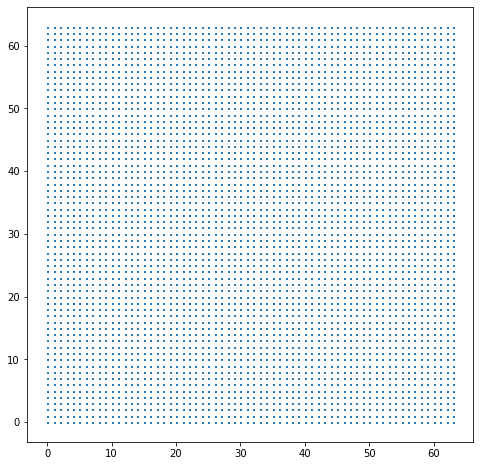

In [22]:
mask = (particles[:,2]==5)
figure(figsize=(8,8))
scatter(particles[mask,0], particles[mask,1], marker='s', s=1)

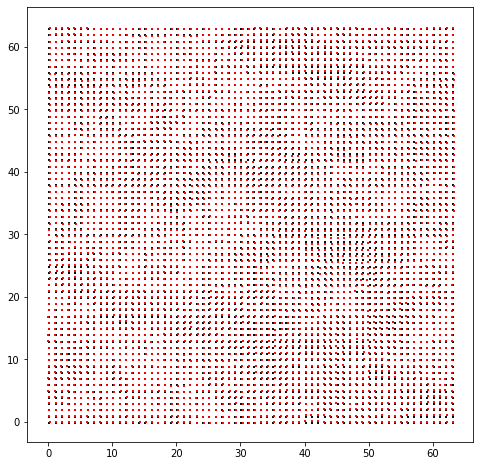

In [23]:
mask = (particles[:,2]==5)
figure(figsize=(8,8))
particles_moved = particles+dx
scatter(particles[mask,0], particles[mask,1], marker='s', s=1, c='k')
scatter(particles_moved[mask,0], particles_moved[mask,1], marker='s', s=1,c='r')

In [24]:
print(dx)

[[-0.0391405   0.11242533 -0.33435452]
 [-0.01666903  0.1005998  -0.31661543]
 [-0.027218    0.13213588 -0.35682255]
 ...
 [-0.04818334  0.02180055 -0.22385484]
 [-0.06575886  0.0605686  -0.21620424]
 [-0.09032343  0.11074955 -0.32406956]]


In [25]:
print(p)

[[-0.00686284  0.01971248 -0.0586252 ]
 [-0.00292272  0.01763901 -0.05551486]
 [-0.00477236  0.0231685  -0.06256471]
 ...
 [-0.00844839  0.00382247 -0.03925036]
 [-0.01153006  0.01062    -0.03790892]
 [-0.01583717  0.01941865 -0.05682185]]


In [26]:
print(f)

[[-0.01805344  0.05185586 -0.15422006]
 [-0.00768854  0.04640137 -0.14603795]
 [-0.01255423  0.0609473  -0.16458337]
 ...
 [-0.02222443  0.01005544 -0.1032524 ]
 [-0.03033108  0.02793709 -0.09972358]
 [-0.04166142  0.05108291 -0.14947616]]


In [27]:
# Evolve the simulation forward
res = odeint(make_ode_fn(nc), [particles+dx, p],
             jnp.concatenate([jnp.atleast_1d(0.1), stages]), cosmo, rtol=1e-5, atol=1e-5)

In [28]:
help(odeint)
# cosmo is required?
# somehow the function knows what a is in in terms of units

Help on function odeint in module jax.experimental.ode:

odeint(func, y0, t, *args, rtol=1.4e-08, atol=1.4e-08, mxstep=inf)
    Adaptive stepsize (Dormand-Prince) Runge-Kutta odeint implementation.
    
    Args:
      func: function to evaluate the time derivative of the solution `y` at time
        `t` as `func(y, t, *args)`, producing the same shape/structure as `y0`.
      y0: array or pytree of arrays representing the initial value for the state.
      t: array of float times for evaluation, like `jnp.linspace(0., 10., 101)`,
        in which the values must be strictly increasing.
      *args: tuple of additional arguments for `func`, which must be arrays
        scalars, or (nested) standard Python containers (tuples, lists, dicts,
        namedtuples, i.e. pytrees) of those types.
      rtol: float, relative local error tolerance for solver (optional).
      atol: float, absolute local error tolerance for solver (optional).
      mxstep: int, maximum number of steps to take for

In [29]:
help(make_ode_fn)

Help on function make_ode_fn in module jaxpm.pm:

make_ode_fn(mesh_shape)



In [30]:
# help(jnp.atleast_1d)
jnp.atleast_1d(np.array([3,3,3,3]))
print(jnp.concatenate([jnp.atleast_1d(0.1), stages]))
# add a=0.1 to the original stages

[0.1        0.29620945 0.30691355 0.31792685 0.3291079  0.34051567
 0.35215685 0.36415777 0.3763312  0.3887628  0.4014616  0.4144375
 0.4278465  0.44145298 0.45537308 0.4696204  0.4842098  0.4991572
 0.5144799  0.5303916  0.5465716  0.56319183 0.5802765  0.5978522
 0.6159475  0.63459384 0.65382487 0.6736778  0.69449717 0.71580267
 0.7378724  0.7607599  0.78452295 0.8092247  0.83493376 0.8621686
 0.8903108  0.919736   0.95054406 0.9832446 ]


In [31]:
print(res) # position and momentum?

[DeviceArray([[[-3.91405039e-02,  1.12425327e-01, -3.34354520e-01],
              [-1.66690350e-02,  1.00599796e-01,  6.83384538e-01],
              [-2.72180028e-02,  1.32135883e-01,  1.64317751e+00],
              ...,
              [ 6.29518166e+01,  6.30218010e+01,  3.16776154e+02],
              [ 6.29342422e+01,  6.30605698e+01,  3.17783783e+02],
              [ 6.29096756e+01,  6.31107483e+01,  3.18675934e+02]],

             [[-1.47501305e-01,  3.34354013e-01, -9.78657901e-01],
              [-8.51105824e-02,  3.19904715e-01,  3.91957499e-02],
              [-9.18852165e-02,  3.87496322e-01,  9.71054912e-01],
              ...,
              [ 6.28445816e+01,  6.30709724e+01,  3.16342865e+02],
              [ 6.27919350e+01,  6.31907158e+01,  3.17316620e+02],
              [ 6.27416801e+01,  6.33113098e+01,  3.18059692e+02]],

             [[-1.54201537e-01,  3.46260667e-01, -1.01269436e+00],
              [-8.96901637e-02,  3.32101375e-01,  4.22250340e-03],
              [-9.5

In [32]:
len(res[0]), len(res[0][0])
# first index is position
# second index is time step (0-initial, 39-final)
# in each time steps there are 64x64x320 grid points that were initially at particles+dx positions in 3D
# after each time step these particles move

(40, 1310720)

In [33]:
64*64*320

1310720

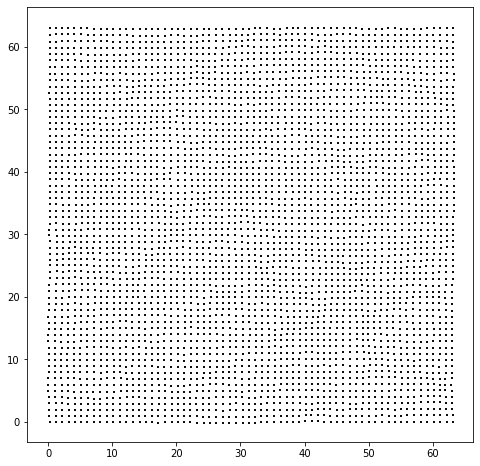

In [34]:
figure(figsize=(8,8))
mask = (particles[:,2]==5)
scatter(res[0][0][mask,0],res[0][0][mask,1], marker='s', s=1, c='k')

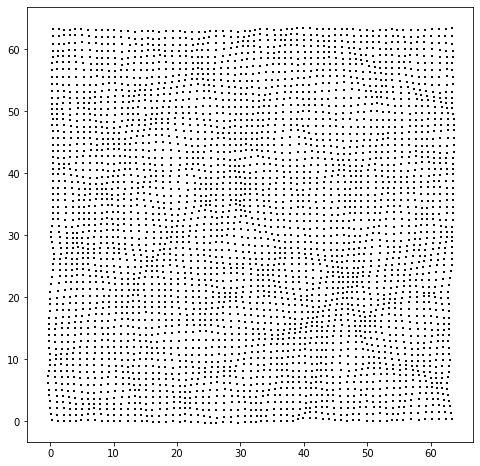

In [35]:
figure(figsize=(8,8))
scatter(res[0][1][mask,0],res[0][1][mask,1], marker='s', s=1, c='k')

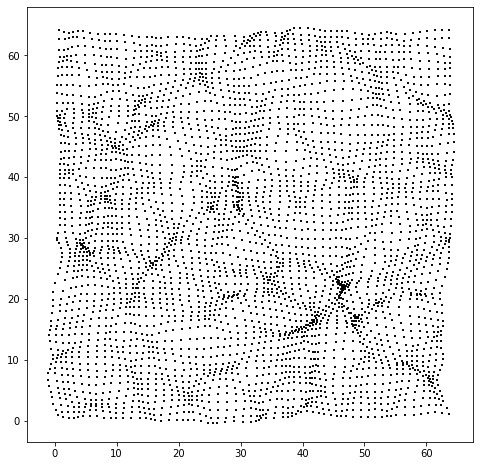

In [36]:
figure(figsize=(8,8))
scatter(res[0][39][mask,0],res[0][39][mask,1], marker='s', s=1, c='k')

<ipython-input-63-21bedfb59280>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure()


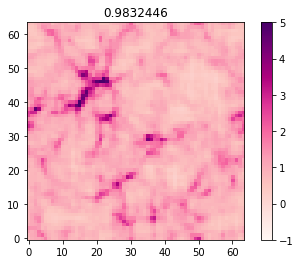

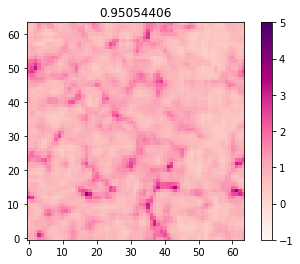

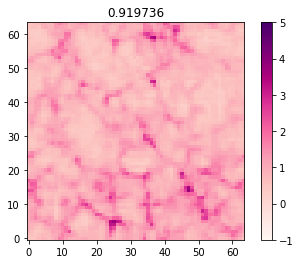

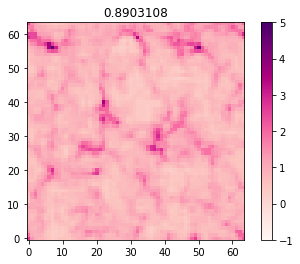

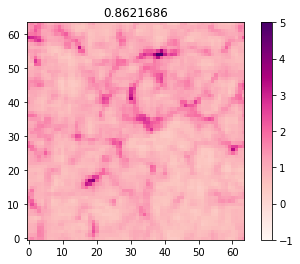

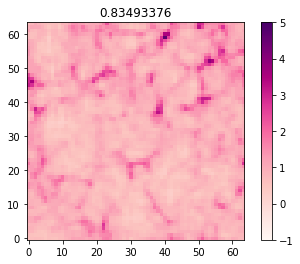

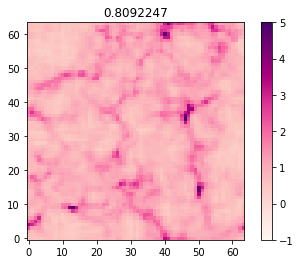

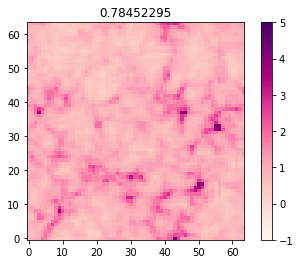

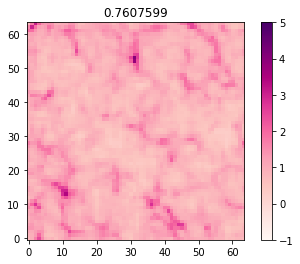

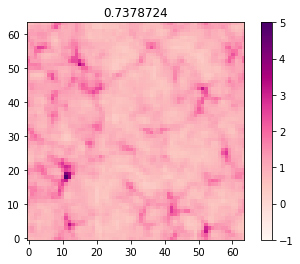

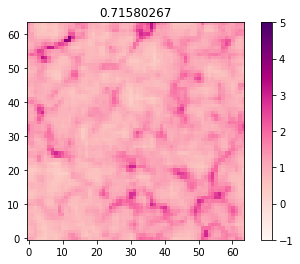

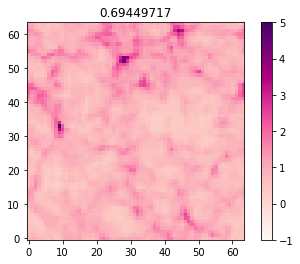

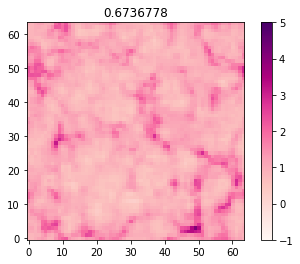

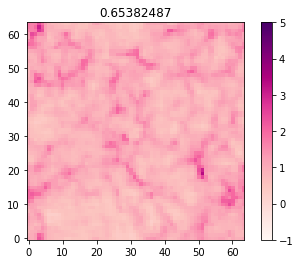

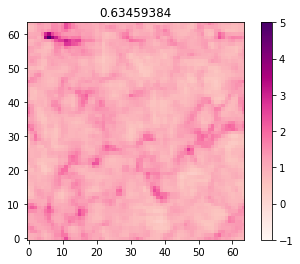

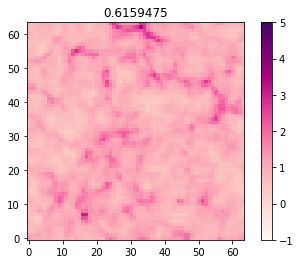

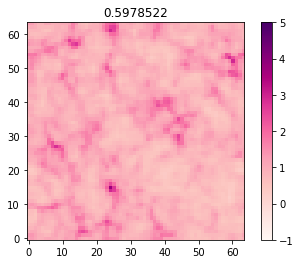

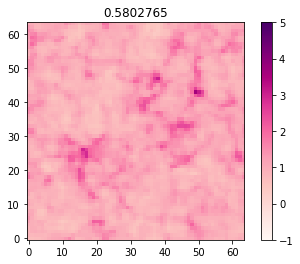

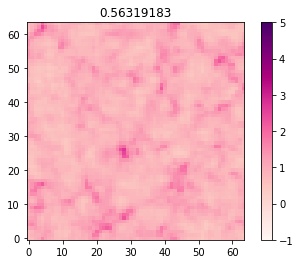

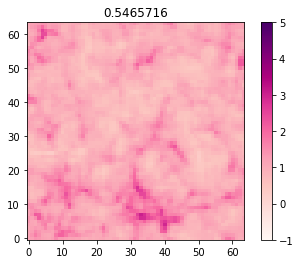

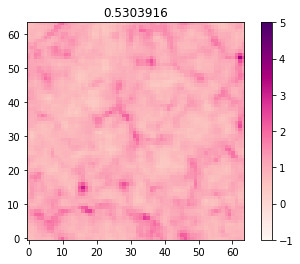

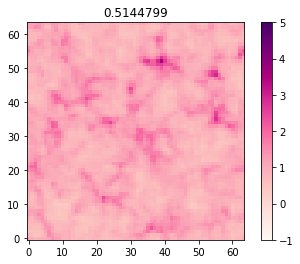

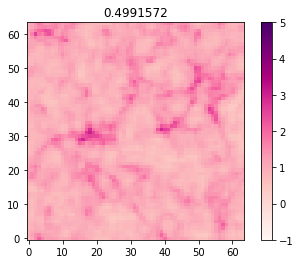

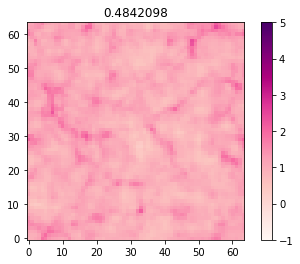

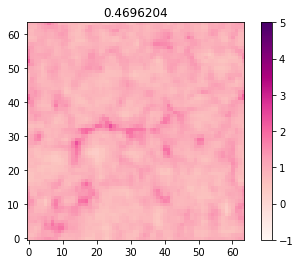

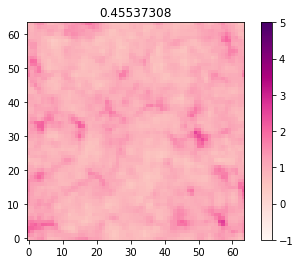

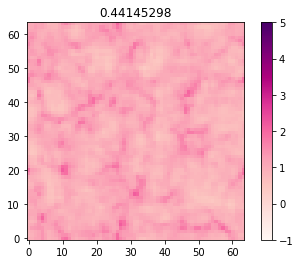

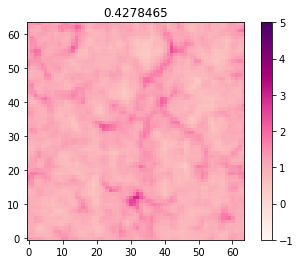

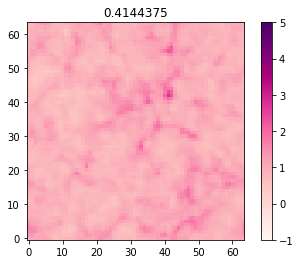

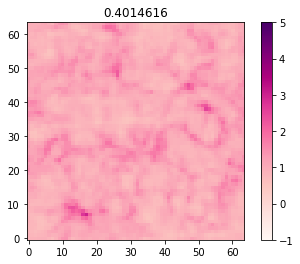

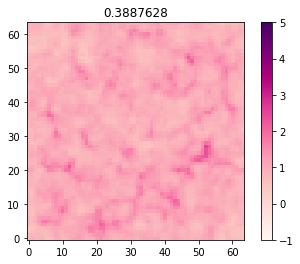

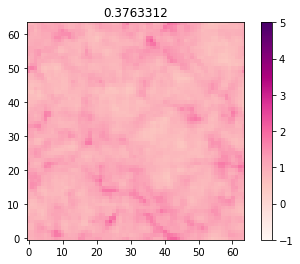

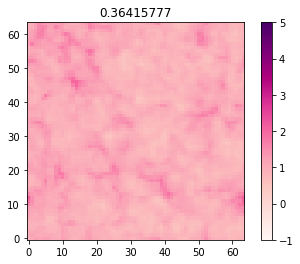

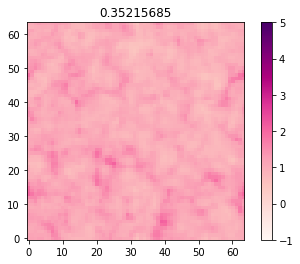

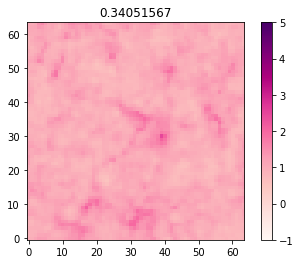

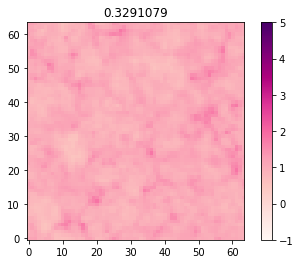

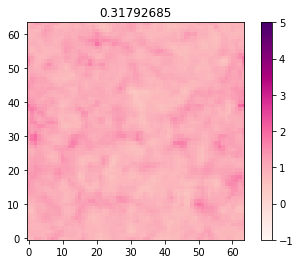

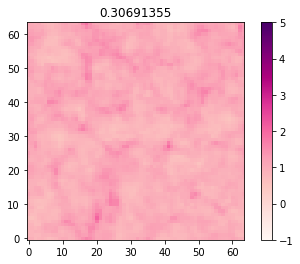

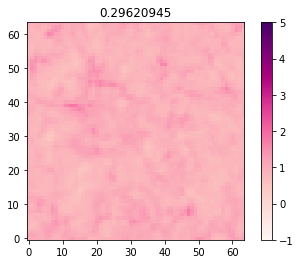

In [63]:
# Extract the lensplanes
lensplanes = []
for i in range(len(a_center)):
    dx = box_size[0]/64
    dz = lensplane_width # in Mpc/h
    plane = density_plane(res[0][::-1][i],
                          nc,
                          (i+0.5)*lensplane_width/box_size[-1]*nc[-1],
                          width=lensplane_width/box_size[-1]*nc[-1],
                          plane_resolution=64
                       )

    lensplanes.append({'r': r_center[i],
                       'a': stages[::-1][i],
                       'plane': plane,
                       'dx':dx,
                       'dz':dz})
    figure()
    imshow(plane, origin='lower', vmin=-1, vmax=5, cmap='RdPu')
    colorbar()
    title(str(a_center[i]))

    savefig('temp_fig/lens_plane_'+str(i)+'.jpg')



In [48]:
# each of these lens planes are cut out from different places in the 64x64x320 grid, effectively independent

In [64]:
import glob
from PIL import Image
def make_gif(frame_folder):
    frames = [Image.open("temp_fig/lens_plane_"+str(i)+".jpg") for i in range(39)[::-1]]
    frame_one = frames[0]
    frame_one.save("lens_plane.gif", format="GIF", append_images=frames,
               save_all=True, duration=150, loop=1)
    
if __name__ == "__main__":
    make_gif("temp_fig")

<ipython-input-61-f984720c07a2>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure()


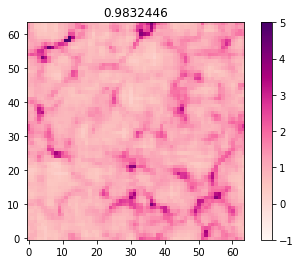

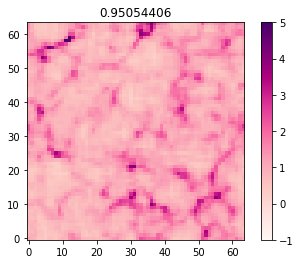

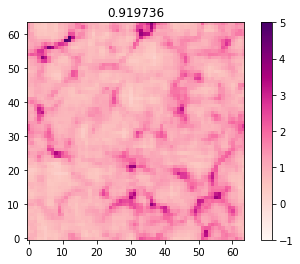

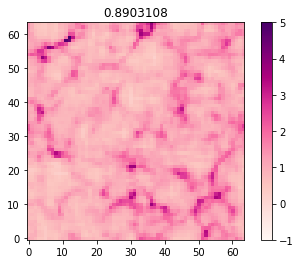

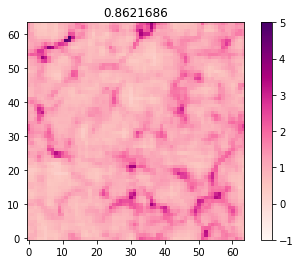

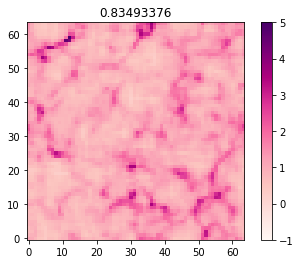

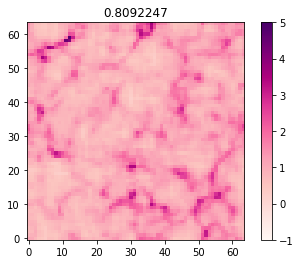

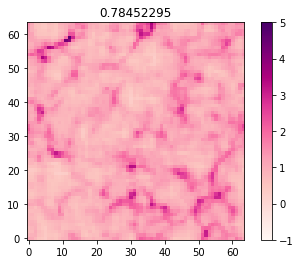

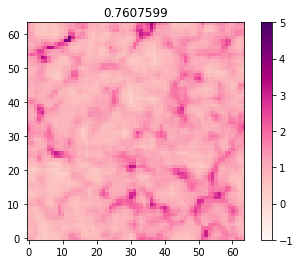

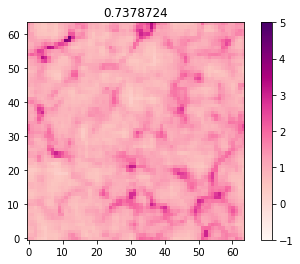

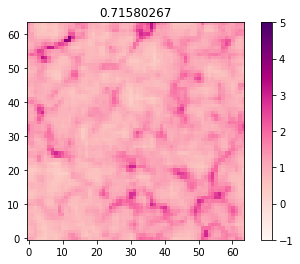

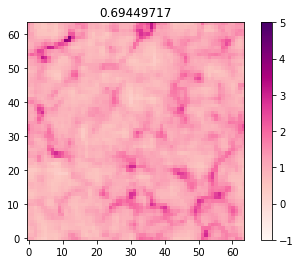

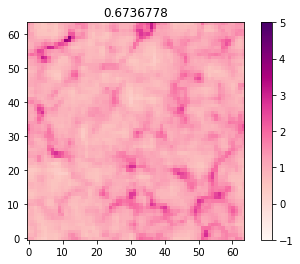

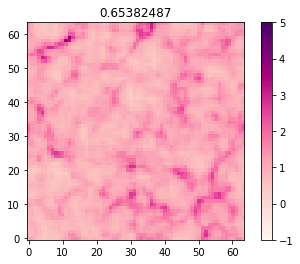

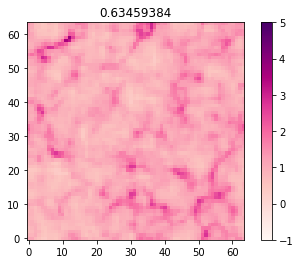

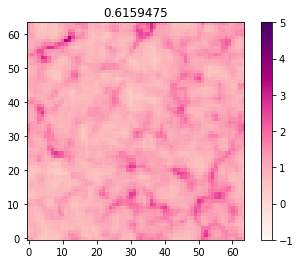

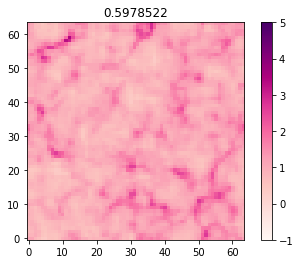

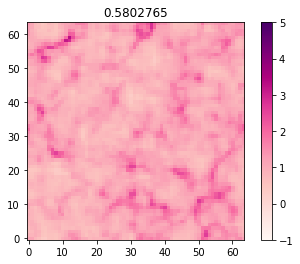

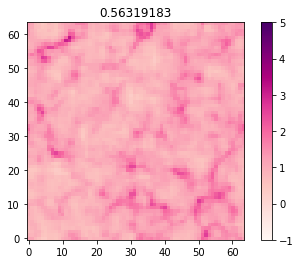

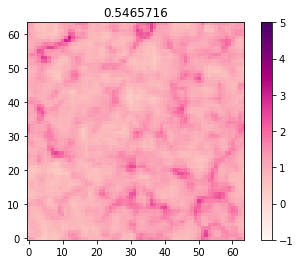

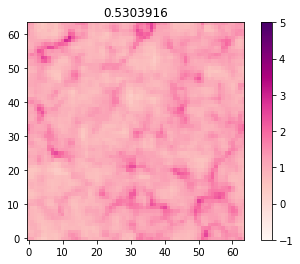

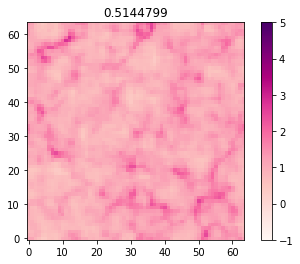

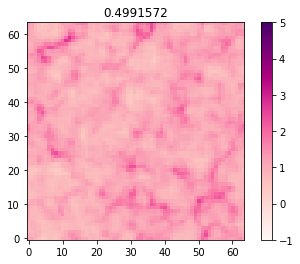

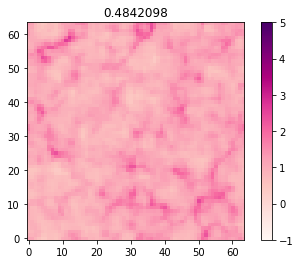

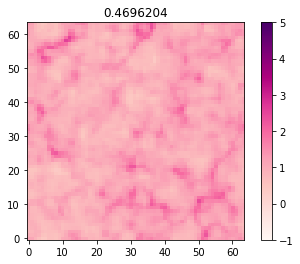

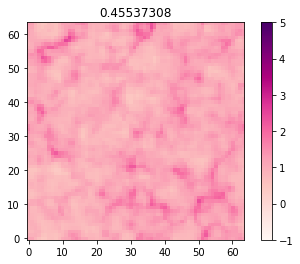

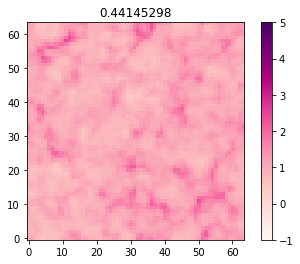

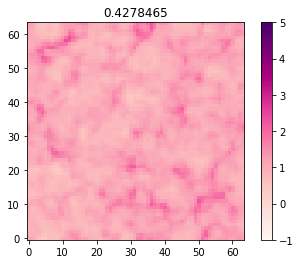

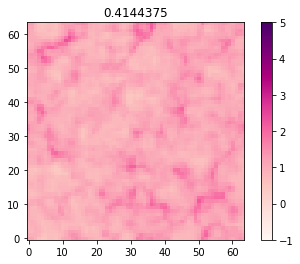

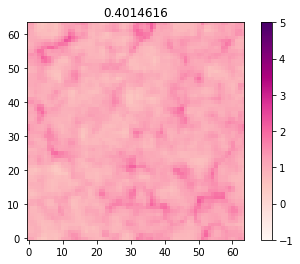

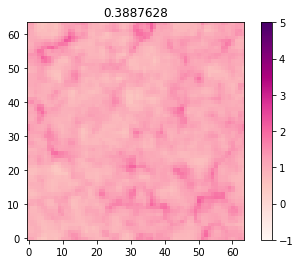

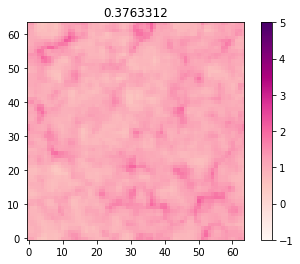

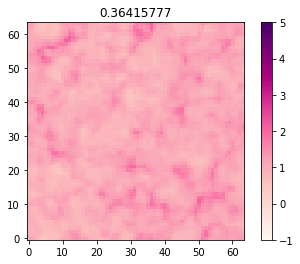

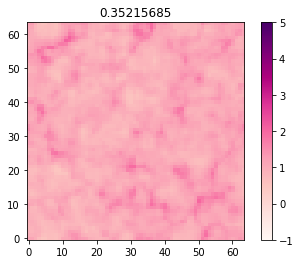

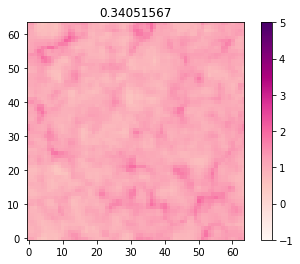

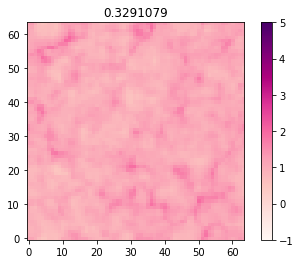

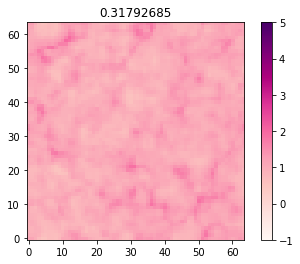

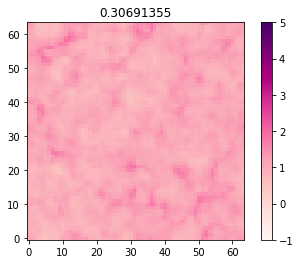

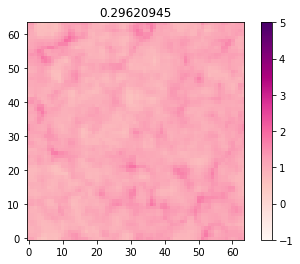

In [61]:
# if we just stick with the same realization
lensplanes = []
for i in range(len(a_center)):
    dx = box_size[0]/64
    dz = lensplane_width # in Mpc/h
    plane = density_plane(res[0][::-1][i],
                          nc,
                          (10+0.5)*lensplane_width/box_size[-1]*nc[-1], # at the same location of the long bix
                          width=lensplane_width/box_size[-1]*nc[-1],
                          plane_resolution=64
                       )

    lensplanes.append({'r': r_center[i],
                       'a': stages[::-1][i],
                       'plane': plane,
                       'dx':dx,
                       'dz':dz})
    figure()
    imshow(plane, origin='lower', vmin=-1, vmax=5, cmap='RdPu')
    colorbar()
    title(str(a_center[i]))

    savefig('temp_fig/fix_lens_plane_'+str(i)+'.jpg')


In [62]:
import glob
from PIL import Image
def make_gif(frame_folder):
    frames = [Image.open("temp_fig/fix_lens_plane_"+str(i)+".jpg") for i in range(39)[::-1]]
    frame_one = frames[0]
    frame_one.save("fix_lens_plane.gif", format="GIF", append_images=frames,
               save_all=True, duration=150, loop=1)
    
if __name__ == "__main__":
    make_gif("temp_fig")

In [164]:
help(density_plane)

Help on function density_plane in module jaxpm.lensing:

density_plane(positions, box_shape, center, width, plane_resolution, smoothing_sigma=None)
    Extacts a density plane from the simulation



In [168]:
print(plane.shape, nc)

(64, 64) [64, 64, 320]


In [163]:
print(dz, dx)

102.5 3.125


In [66]:
# Get convergence map
m = convergence_Born(cosmology,
                      lensplanes,
                      coords=jnp.array(c).T.reshape(2,field_npix,field_npix),
                      z_source=z_source)

In [65]:
help(convergence_Born)

Help on function convergence_Born in module jaxpm.lensing:

convergence_Born(cosmo, density_planes, coords, z_source)
    Compute the Born convergence
    Args:
      cosmo: `Cosmology`, cosmology object.
      density_planes: list of dictionaries (r, a, density_plane, dx, dz), lens planes to use 
      coords: a 3-D array of angular coordinates in radians of N points with shape [batch, N, 2].
      z_source: 1-D `Tensor` of source redshifts with shape [Nz] .
      name: `string`, name of the operation.
    Returns:
      `Tensor` of shape [batch_size, N, Nz], of convergence values.



In [81]:
print(jnp.array(c).T.reshape(2,field_npix,field_npix))
print(field_npix)
print(jnp.array(c).T.reshape(2,field_npix,field_npix).shape)
# not sure why this is consistent with "radians of N points with shape [batch, N, 2]"
print(len(z_source))


[[[0.         0.00068177 0.00136354 ... 0.08522116 0.08590292 0.08658469]
  [0.         0.00068177 0.00136354 ... 0.08522116 0.08590292 0.08658469]
  [0.         0.00068177 0.00136354 ... 0.08522116 0.08590292 0.08658469]
  ...
  [0.         0.00068177 0.00136354 ... 0.08522116 0.08590292 0.08658469]
  [0.         0.00068177 0.00136354 ... 0.08522116 0.08590292 0.08658469]
  [0.         0.00068177 0.00136354 ... 0.08522116 0.08590292 0.08658469]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.00068177 0.00068177 0.00068177 ... 0.00068177 0.00068177 0.00068177]
  [0.00136354 0.00136354 0.00136354 ... 0.00136354 0.00136354 0.00136354]
  ...
  [0.08522116 0.08522116 0.08522116 ... 0.08522116 0.08522116 0.08522116]
  [0.08590292 0.08590292 0.08590292 ... 0.08590292 0.08590292 0.08590292]
  [0.08658469 0.08658469 0.08658469 ... 0.08658469 0.08658469 0.08658469]]]
128
(2, 128, 128)
50


In [79]:
m.shape

(50, 128, 128)

<ipython-input-84-61fa7ecbe5de>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure()


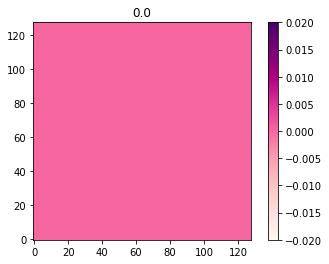

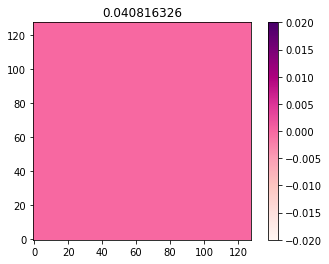

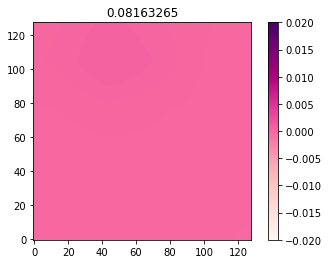

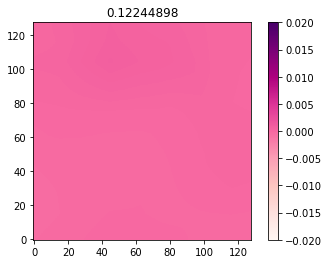

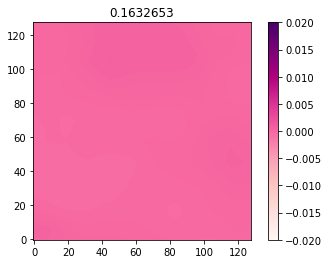

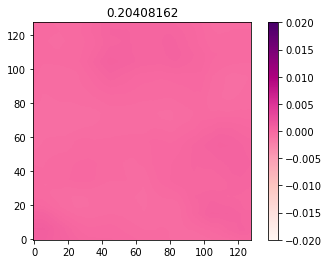

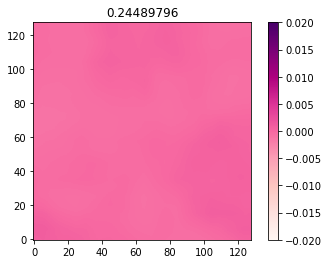

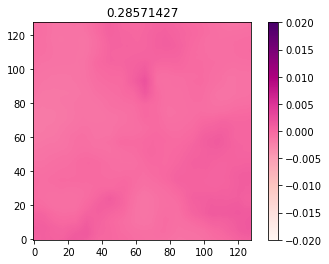

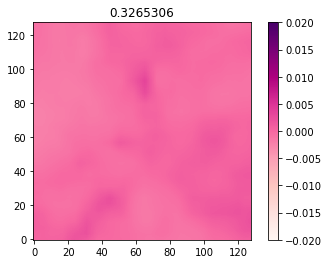

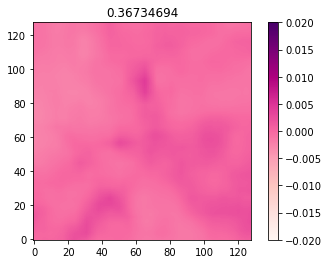

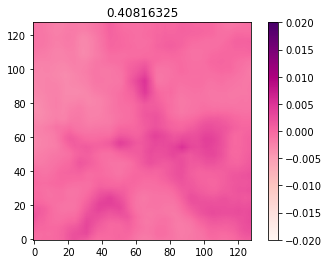

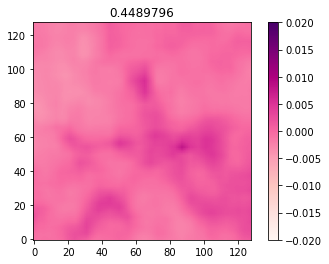

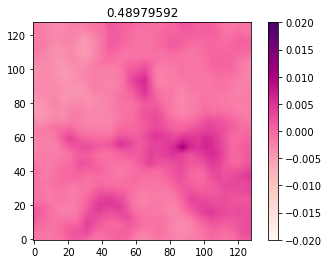

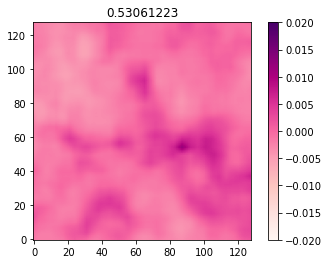

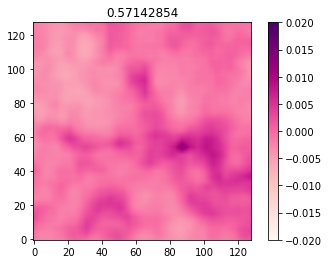

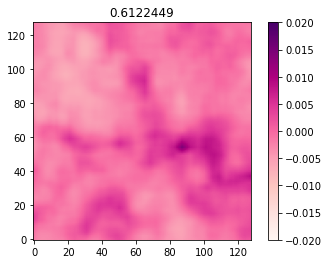

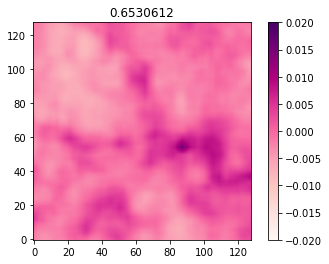

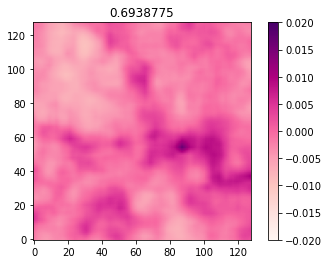

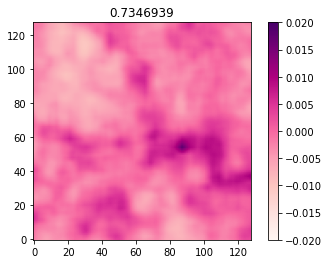

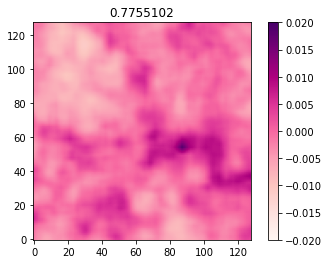

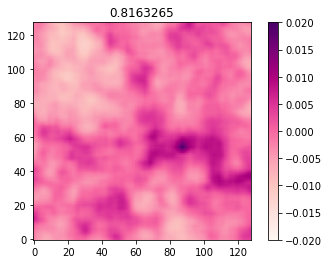

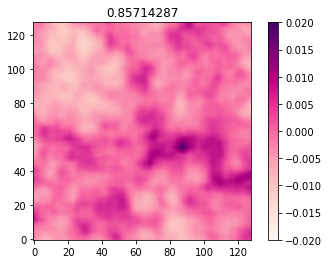

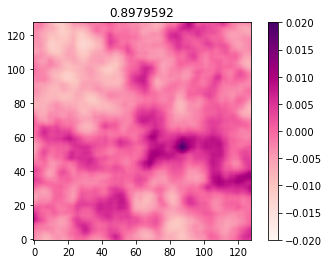

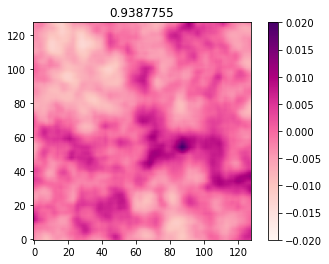

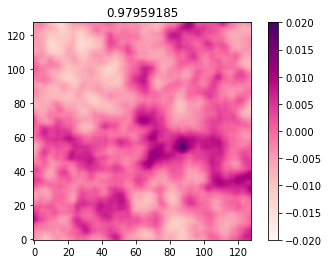

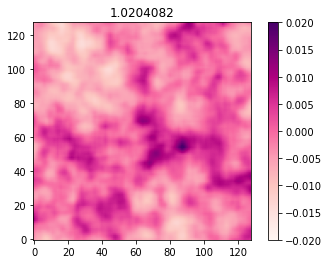

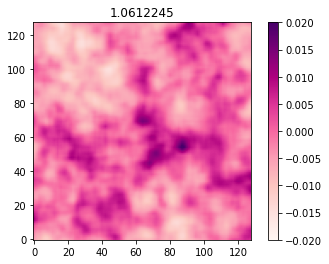

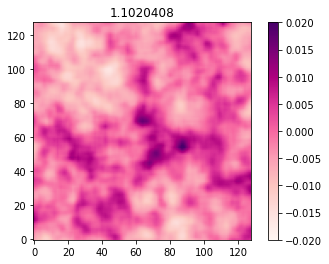

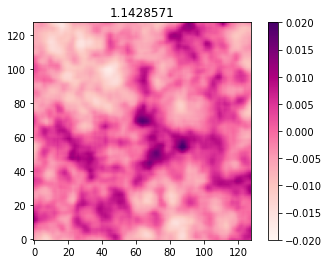

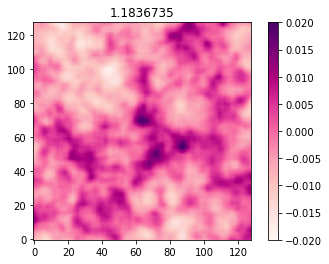

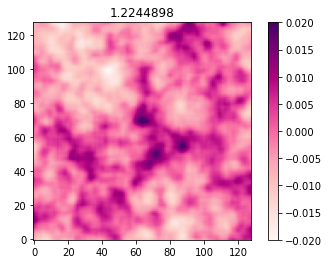

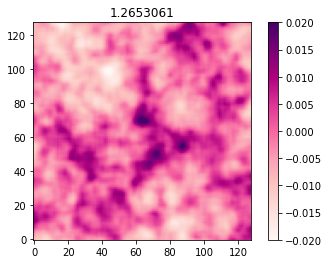

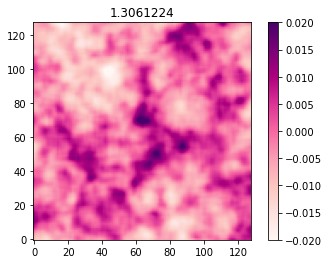

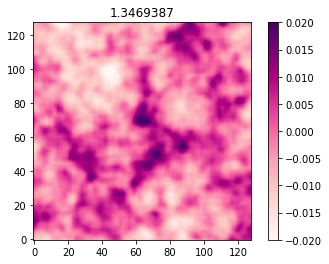

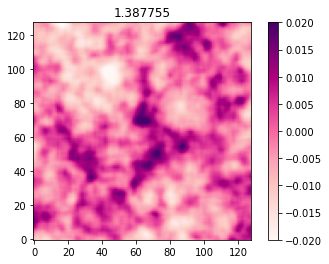

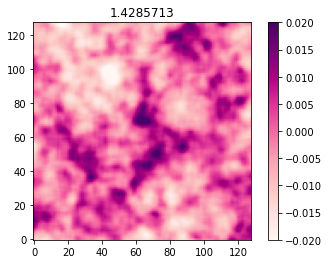

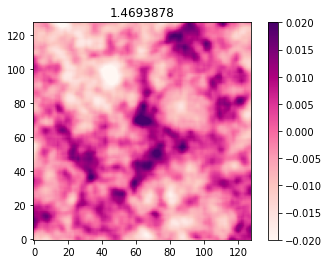

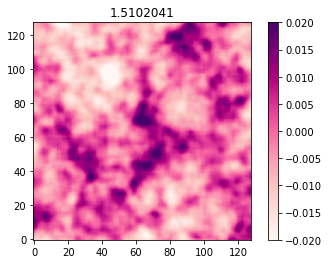

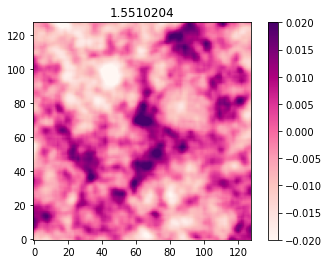

In [84]:
for i in range(len(a_center)):
    figure()
    imshow(m[i,:,:], vmin=-0.02, vmax=0.02, origin='lower', cmap='RdPu')
    colorbar()
    title(str(z_source[i]))